In [3]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

In [4]:
data_path = "../data/combined_data.csv"

In [5]:
df = pd.read_csv(data_path)

In [6]:
df.head()

,Unnamed: 0,Time,Speed Follower,Speed Leader,Smooth Speed Follower,Smooth Speed Leader,Spacing,file_path,gap_setting,desired_speed,free_flow_speed,speed_fluctuation
0,0,2033.00,55.31,55.130,54.9484,55.1524,27.307067,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0
1,1,2033.02,55.17,55.255,54.9588,55.1654,27.315506,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0
2,2,2033.04,55.03,55.380,54.9626,55.1838,27.323949,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0
3,3,2033.06,55.04,55.430,54.9658,55.2046,27.319727,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0
4,4,2033.08,55.05,55.480,54.9726,55.2198,27.315506,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0


### Divide the dataset based on the gap setting

In [7]:
medium_gap_df = df[df['gap_setting']=='Medium']

In [8]:
medium_gap_df.shape

(181318, 12)

In [9]:
short_gap_df = df[df['gap_setting']=='Short']
long_gap_df = df[df['gap_setting']=='Long']
xlong_gap_df = df[df['gap_setting']=='XLong']

In [10]:
medium_gap_df.shape,short_gap_df.shape,long_gap_df.shape,xlong_gap_df.shape

((181318, 12), (184718, 12), (181868, 12), (193268, 12))

In [11]:
medium_gap_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181318 entries, 181868 to 363185
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             181318 non-null  int64  
 1   Time                   181318 non-null  float64
 2   Speed Follower         181318 non-null  float64
 3   Speed Leader           181318 non-null  float64
 4   Smooth Speed Follower  181318 non-null  float64
 5   Smooth Speed Leader    181318 non-null  float64
 6   Spacing                181318 non-null  float64
 7   file_path              181318 non-null  object 
 8   gap_setting            181318 non-null  object 
 9   desired_speed          181318 non-null  int64  
 10  free_flow_speed        181318 non-null  int64  
 11  speed_fluctuation      181318 non-null  int64  
dtypes: float64(6), int64(4), object(2)
memory usage: 18.0+ MB


### Calibration

In [12]:
# initial_params = [30.0, 1.5, 2.0, 1.0, 1.5]


# Define the IDM model
def idm_model(params, time, lead_speed, initial_spacing, initial_speed):
    v0, T, s0, a_max, b = params
    spacing = [initial_spacing]
    speed = [initial_speed]
    for t in range(1, len(time)):
        dt = time[t] - time[t-1]
        delta_v = lead_speed[t-1] - speed[-1]
        s_star = s0 + speed[-1] * T + (speed[-1] * delta_v) / (2 * np.sqrt(a_max * b))
        a = a_max * (1 - (speed[-1] / v0)**4 - (s_star / spacing[-1])**2)
        v_new = speed[-1] + a * dt
        s_new = spacing[-1] + (lead_speed[t-1] - speed[-1]) * dt
        spacing.append(s_new)
        speed.append(v_new)
    return np.array(spacing), np.array(speed)

In [13]:
# (time_subset, lead_speed_subset, experimental_spacing_subset, initial_spacing, initial_speed

In [14]:
# Define the objective function (spacing RMSE)
def objective(params, time, lead_speed, experimental_spacing, initial_spacing, initial_speed):
    simulated_spacing, _ = idm_model(params, time, lead_speed, initial_spacing, initial_speed)
    rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing)**2))
    return rmse

In [40]:
def calibaration_start(df):
    
    # Split the data into six subsets (each 200 seconds long)
    subset_length = int(200 / 0.02)  # 200 seconds, assuming 0.02-second time steps
    num_subsets = 6
    subsets = [df.iloc[i * subset_length:(i + 1) * subset_length] for i in range(num_subsets)]

    print(f"Number of Subset: {len(subsets)}")
    # Calibrate on each subset
    best_rmse = np.inf
    best_params = None

    for i, subset in enumerate(subsets):
        print(f"-------------------Calibrating on subset {i+1}-------------------")

        # Extract data for the subset
        time_subset = subset['Time'].values
        lead_speed_subset = subset['Speed Leader'].values
        follow_speed_subset = subset['Speed Follower'].values
        experimental_spacing_subset = subset['Spacing'].values

        # Initial conditions
        initial_spacing = experimental_spacing_subset[0]
        initial_speed = follow_speed_subset[0]

        # Initial guess for parameters
#         initial_params = [0.5, 0.5, 2.0, 1.5]
        
        initial_params = [33.3, 2.0, 1.6, 5.0, 1.67]

        # Bounds for parameters
#         bounds = [(0, None), (0, None), (0, None), (0, None)]
#         bounds = [(25.0, 45.0), (1, 2.5), (1.0, 5.0), (0.5, 2.0), (1.0, 2.0)]
        bounds = [(20.0, 30.0), (1.0, 3.0), (1.0, 5.0), (0.5, 2.0), (1.0, 2.0)]

        # Run optimization
        result = minimize(objective, initial_params, args=(time_subset, lead_speed_subset, experimental_spacing_subset, initial_spacing, initial_speed),
                         bounds=bounds, method='L-BFGS-B')

        # Simulate with the calibrated parameters
        simulated_spacing, _ = idm_model(result.x, time_subset, lead_speed_subset, initial_spacing, initial_speed)

        print(f"Simulated Spacing: {len(simulated_spacing)}")
        print(f"Experimental Spacing: {len(experimental_spacing_subset)}")
        rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing_subset)**2))

        # Check if this is the best model so far
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = result.x

        print(f"Subset {i+1} RMSE: {rmse:.4f}")
        print(f"Params: {result.x}")
    print("-------------------------------------------------")
    print(f"Best params: {best_params} \nBest RMSE : {best_rmse}")
    return best_params,best_rmse

def test_and_viz_full_dataset(df, best_params, limit=None):

    # Extract relevant columns
    time = np.arange(0, len(df) * 0.02, 0.02)  # Assuming time increments by 0.02 seconds
    lead_speed = df['Speed Leader'].values
    follow_speed = df['Speed Follower'].values
    experimental_spacing = df['Spacing'].values  # Assuming this is the spacing

    # Test the best model on the entire dataset
    simulated_spacing_full, simulated_speed_full = idm_model(best_params, time, lead_speed, experimental_spacing[0], follow_speed[0])
    rmse_full = np.sqrt(np.mean((simulated_spacing_full - experimental_spacing)**2))
    print("-----------------------------------------------------------------------------")
    print(f"Full dataset RMSE: {rmse_full:.4f}")
    
    # Apply the limit to the data
    if limit is not None:
        start, end = limit
        mask = (time >= start) & (time <= end)
        time = time[mask]
        experimental_spacing = experimental_spacing[mask]
        simulated_spacing_full = simulated_spacing_full[mask]
        follow_speed = follow_speed[mask]
        simulated_speed_full = simulated_speed_full[mask]
        lead_speed = lead_speed[mask]
    
    # Visualize the results
    import matplotlib.pyplot as plt

    # Plot simulated vs experimental spacing
    plt.figure(figsize=(12, 6))
    plt.plot(time, experimental_spacing, label='Experimental Spacing', color='blue', linestyle='-', linewidth=2)
    plt.plot(time, simulated_spacing_full, label='Simulated Spacing', color='red', linestyle='-', linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Spacing (m)')
    plt.title(f'Simulated vs Experimental Spacing')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot simulated vs experimental speed (including leader speed)
    plt.figure(figsize=(12, 6))
    plt.plot(time, follow_speed, label='Experimental Follower Speed', color='blue', linestyle='-', linewidth=2)
    plt.plot(time, simulated_speed_full, label='Simulated Follower Speed', color='red', linestyle='-', linewidth=2)
    plt.plot(time, lead_speed, label='Leader Speed', color='green', linestyle='-', linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (m/s)')
    plt.title(f'Simulated vs Experimental Speed')
    plt.legend()
    plt.grid(True)
    plt.show()


In [41]:
# from sklearn.metrics import mean_squared_error, r2_score

# # Compute RMSE for spacing
# spacing_rmse = np.sqrt(mean_squared_error(experimental_spacing, simulated_spacing))
# print(f"Spacing RMSE: {spacing_rmse:.4f}")

# # Compute RMSE for speed
# speed_rmse = np.sqrt(mean_squared_error(follow_speed, simulated_speed))
# print(f"Speed RMSE: {speed_rmse:.4f}")

# # Compute R² for spacing
# spacing_r2 = r2_score(experimental_spacing, simulated_spacing)
# print(f"Spacing R²: {spacing_r2:.4f}")

# # Compute R² for speed
# speed_r2 = r2_score(follow_speed, simulated_speed)
# print(f"Speed R²: {speed_r2:.4f}")

In [42]:
medium_gap_best_params,medium_gap_best_rmse = calibaration_start(medium_gap_df)

Number of Subset: 6
-------------------Calibrating on subset 1-------------------


/tmp/ipykernel_51446/3630283029.py:9: RuntimeWarning: overflow encountered in scalar multiply
  s_star = s0 + speed[-1] * T + (speed[-1] * delta_v) / (2 * np.sqrt(a_max * b))
/tmp/ipykernel_51446/3630283029.py:10: RuntimeWarning: overflow encountered in scalar power
  a = a_max * (1 - (speed[-1] / v0)**4 - (s_star / spacing[-1])**2)
/tmp/ipykernel_51446/3630283029.py:10: RuntimeWarning: invalid value encountered in scalar divide
  a = a_max * (1 - (speed[-1] / v0)**4 - (s_star / spacing[-1])**2)


Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 1 RMSE: nan
Params: [30.    2.    1.6   2.    1.67]
-------------------Calibrating on subset 2-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 2 RMSE: nan
Params: [30.    2.    1.6   2.    1.67]
-------------------Calibrating on subset 3-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 3 RMSE: 7896.9687
Params: [30.  1.  1.  2.  2.]
-------------------Calibrating on subset 4-------------------


/tmp/ipykernel_51446/2752833236.py:4: RuntimeWarning: overflow encountered in square
  rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing)**2))


Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 4 RMSE: nan
Params: [30.    2.    1.6   2.    1.67]
-------------------Calibrating on subset 5-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 5 RMSE: 11985.6092
Params: [30.    2.    1.6   2.    1.67]
-------------------Calibrating on subset 6-------------------


/tmp/ipykernel_51446/1505015419.py:45: RuntimeWarning: overflow encountered in square
  rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing_subset)**2))


Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 6 RMSE: 24147.5109
Params: [30.    2.    1.6   2.    1.67]
-------------------------------------------------
Best params: [30.  1.  1.  2.  2.] 
Best RMSE : 7896.968688625408


-----------------------------------------------------------------------------
Full dataset RMSE: 64037.5599


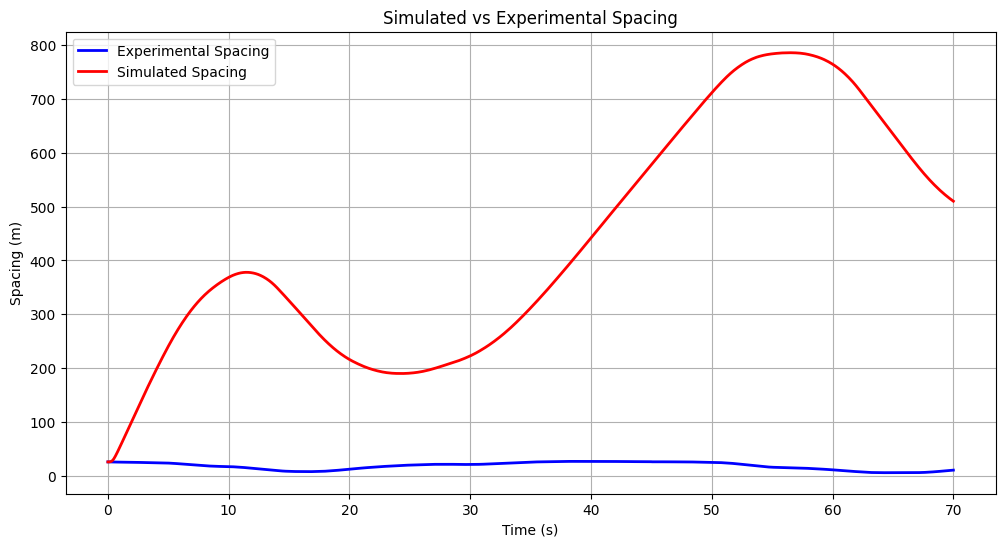

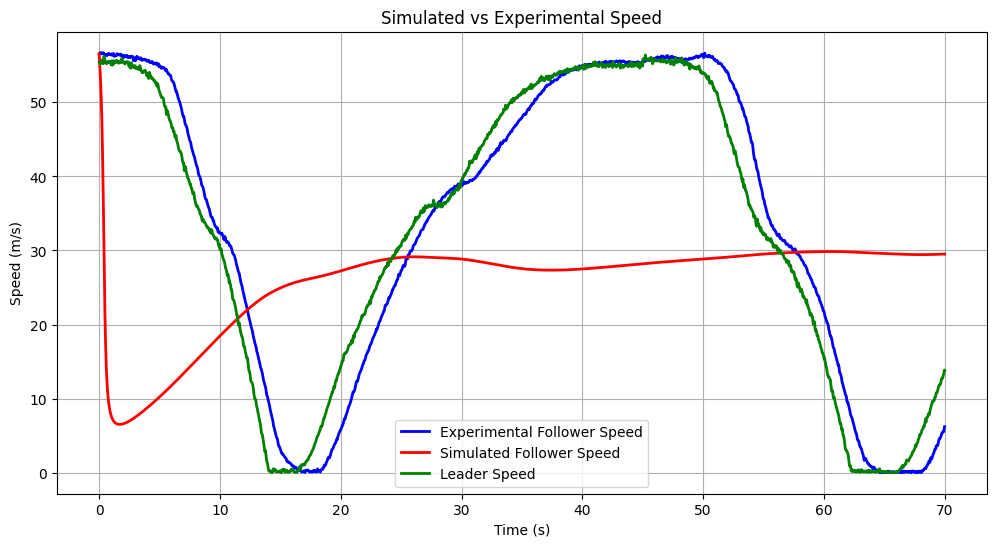

In [43]:
test_and_viz_full_dataset(medium_gap_df,medium_gap_best_params,limit=(0, 70))

In [24]:
short_gap_best_params,short_gap_best_rmse = calibaration_start(short_gap_df)

Number of Subset: 6
-------------------Calibrating on subset 1-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 1 RMSE: 2.5994
Params: [43.67177426 19.10447235  9.54932881  0.24748276]
-------------------Calibrating on subset 2-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 2 RMSE: 2.9818
Params: [1.92365715 3.14700869 8.24434388 0.27943379]
-------------------Calibrating on subset 3-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 3 RMSE: 3.5255
Params: [61.38320477 26.55580957 10.22928383  0.25886398]
-------------------Calibrating on subset 4-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 4 RMSE: 4.0321
Params: [ 0.87079719  3.87994794 12.39996622  0.2311233 ]
-------------------Calibrating on subset 5-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 5 RMSE: 2.6501
Params: [ 0.08373809  3.55544056 21.2421391   0.17114454]
---------

-----------------------------------------------------------------------------
Full dataset RMSE: 3.9659


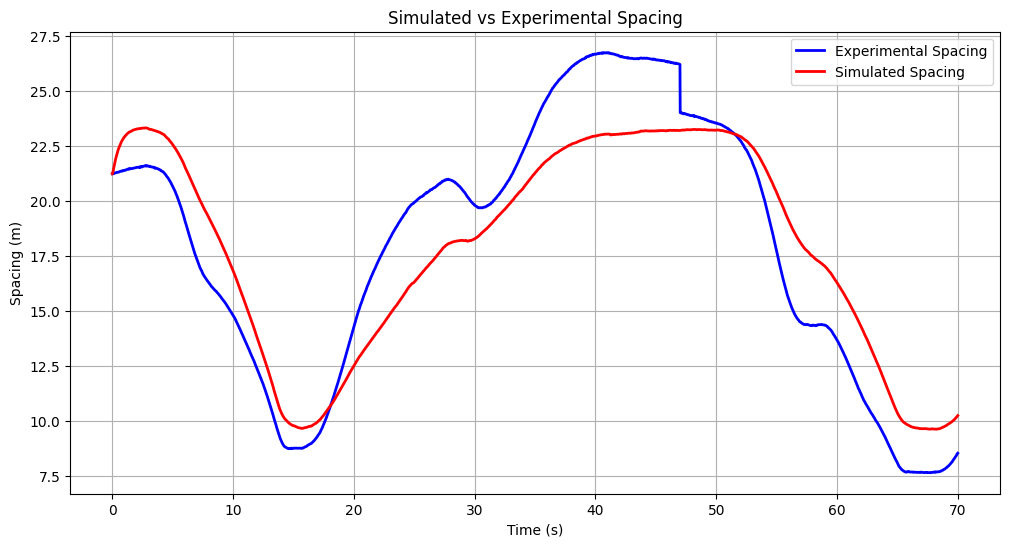

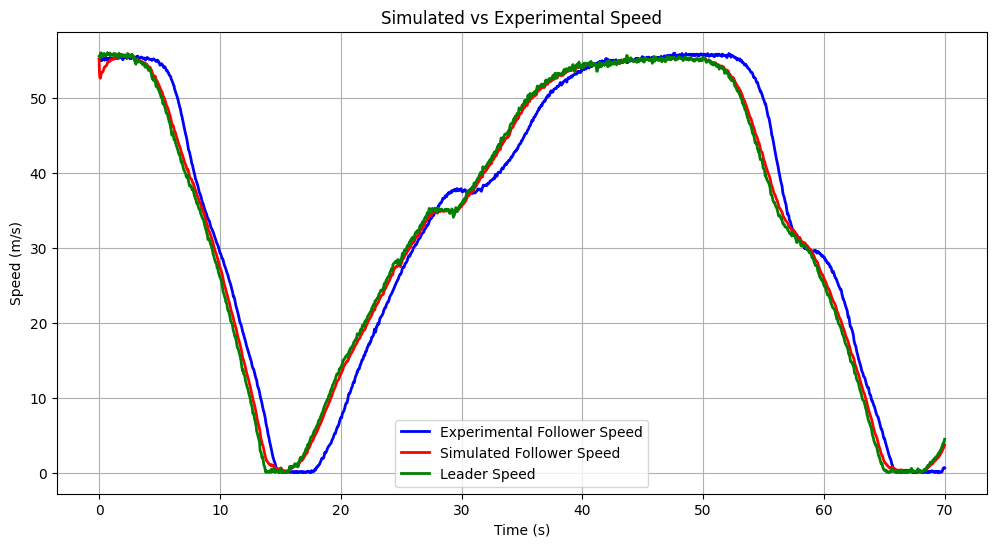

In [25]:
test_and_viz_full_dataset(short_gap_df,short_gap_best_params,limit=(0, 70))

In [26]:
long_gap_best_params,long_gap_best_rms = calibaration_start(long_gap_df)

Number of Subset: 6
-------------------Calibrating on subset 1-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 1 RMSE: 2.5858
Params: [0.63825796 2.33541063 6.9088646  0.41450523]
-------------------Calibrating on subset 2-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 2 RMSE: 2.1070
Params: [12.10549514  4.55928459  7.43749176  0.43013047]
-------------------Calibrating on subset 3-------------------


/tmp/ipykernel_50224/177157701.py:8: RuntimeWarning: overflow encountered in scalar add
  a = k1 * (spacing[-1] - eta - tau * speed[-1]) + k2 * (lead_speed[t-1] - speed[-1])
/tmp/ipykernel_50224/177157701.py:9: RuntimeWarning: invalid value encountered in scalar add
  v_new = speed[-1] + a * dt
/tmp/ipykernel_50224/3247587361.py:7: RuntimeWarning: overflow encountered in square
  rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing_subset)**2))
/tmp/ipykernel_50224/177157701.py:8: RuntimeWarning: overflow encountered in scalar multiply
  a = k1 * (spacing[-1] - eta - tau * speed[-1]) + k2 * (lead_speed[t-1] - speed[-1])
/tmp/ipykernel_50224/177157701.py:8: RuntimeWarning: invalid value encountered in scalar multiply
  a = k1 * (spacing[-1] - eta - tau * speed[-1]) + k2 * (lead_speed[t-1] - speed[-1])


Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 3 RMSE: 5.3567
Params: [79.90678037 57.6018961  21.29775444  0.20575773]
-------------------Calibrating on subset 4-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 4 RMSE: 5.2727
Params: [ 0.49609507  2.30561576 12.03875715  0.38549944]
-------------------Calibrating on subset 5-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 5 RMSE: 1.8212
Params: [ 0.02928567  2.14732012 15.11606382  0.36288081]
-------------------Calibrating on subset 6-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 6 RMSE: 10.4737
Params: [55.97397952 51.42765712 26.524637    0.16615547]
-------------------------------------------------
Best params: [ 0.02928567  2.14732012 15.11606382  0.36288081] 
Best RMSE : 1.8212149689059307


-----------------------------------------------------------------------------
Full dataset RMSE: 3.5102


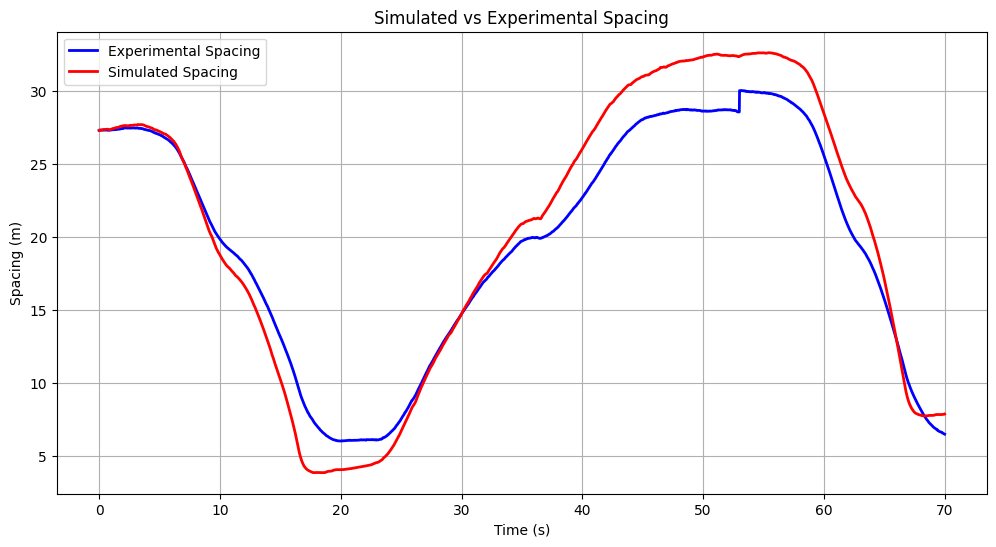

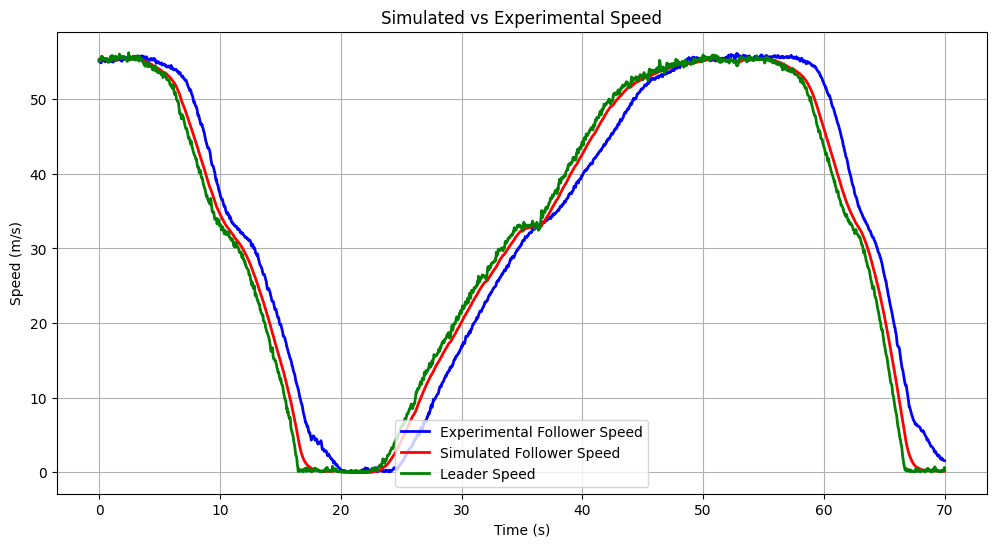

In [27]:
test_and_viz_full_dataset(long_gap_df,long_gap_best_params,limit=(0, 70))

In [28]:
xlong_gap_best_params,xlong_gap_best_rms = calibaration_start(xlong_gap_df)

Number of Subset: 6
-------------------Calibrating on subset 1-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 1 RMSE: 2.8268
Params: [0.17351653 1.93248832 8.12116302 0.49176882]
-------------------Calibrating on subset 2-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 2 RMSE: 12.4562
Params: [5.10256747e-04 9.87172984e+00 1.84536433e+00 0.00000000e+00]
-------------------Calibrating on subset 3-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 3 RMSE: 2.1059
Params: [0.39420798 1.7048895  6.88923239 0.56211871]
-------------------Calibrating on subset 4-------------------


/tmp/ipykernel_50224/177157701.py:8: RuntimeWarning: overflow encountered in scalar add
  a = k1 * (spacing[-1] - eta - tau * speed[-1]) + k2 * (lead_speed[t-1] - speed[-1])
/tmp/ipykernel_50224/177157701.py:9: RuntimeWarning: invalid value encountered in scalar add
  v_new = speed[-1] + a * dt
/tmp/ipykernel_50224/3247587361.py:7: RuntimeWarning: overflow encountered in square
  rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing_subset)**2))
/tmp/ipykernel_50224/177157701.py:8: RuntimeWarning: overflow encountered in scalar multiply
  a = k1 * (spacing[-1] - eta - tau * speed[-1]) + k2 * (lead_speed[t-1] - speed[-1])
/tmp/ipykernel_50224/177157701.py:8: RuntimeWarning: invalid value encountered in scalar multiply
  a = k1 * (spacing[-1] - eta - tau * speed[-1]) + k2 * (lead_speed[t-1] - speed[-1])


Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 4 RMSE: 5.1658
Params: [ 8.50799402 18.37413128 10.72876948  0.54495091]
-------------------Calibrating on subset 5-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 5 RMSE: 2.5314
Params: [1.57154567 1.84582375 7.30910097 0.60061412]
-------------------Calibrating on subset 6-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 6 RMSE: 12.4167
Params: [49.94120657 74.51075819 23.95768168  0.33853083]
-------------------------------------------------
Best params: [0.39420798 1.7048895  6.88923239 0.56211871] 
Best RMSE : 2.1058922936667757


/home/paridhi/AARC/car-following-behavior-EVACC-paper-recreation/carenv/lib/python3.10/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/paridhi/AARC/car-following-behavior-EVACC-paper-recreation/carenv/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


-----------------------------------------------------------------------------
Full dataset RMSE: 2.9073


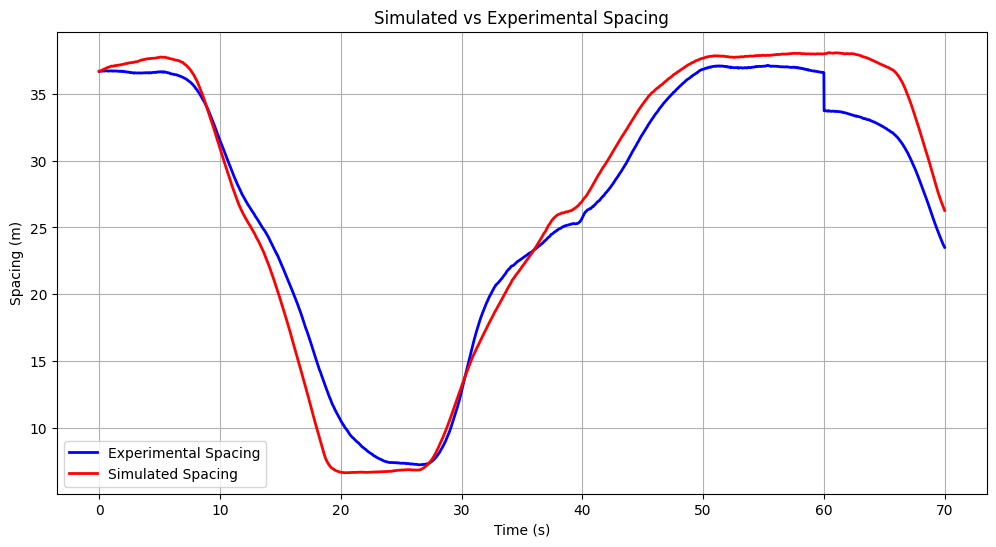

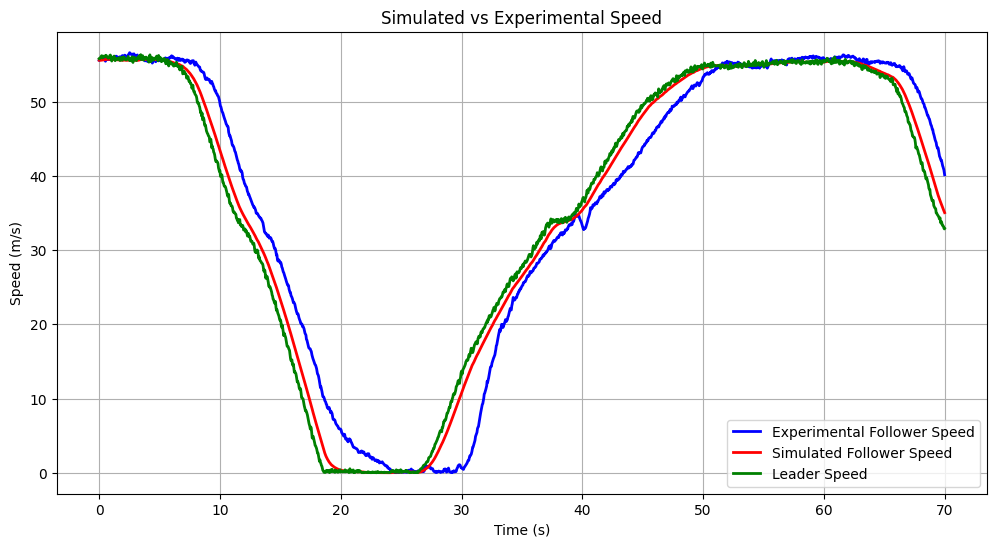

In [29]:
test_and_viz_full_dataset(xlong_gap_df,xlong_gap_best_params,limit=(0, 70))

-----------------------------------------------------------------------------
Full dataset RMSE: 2.9073


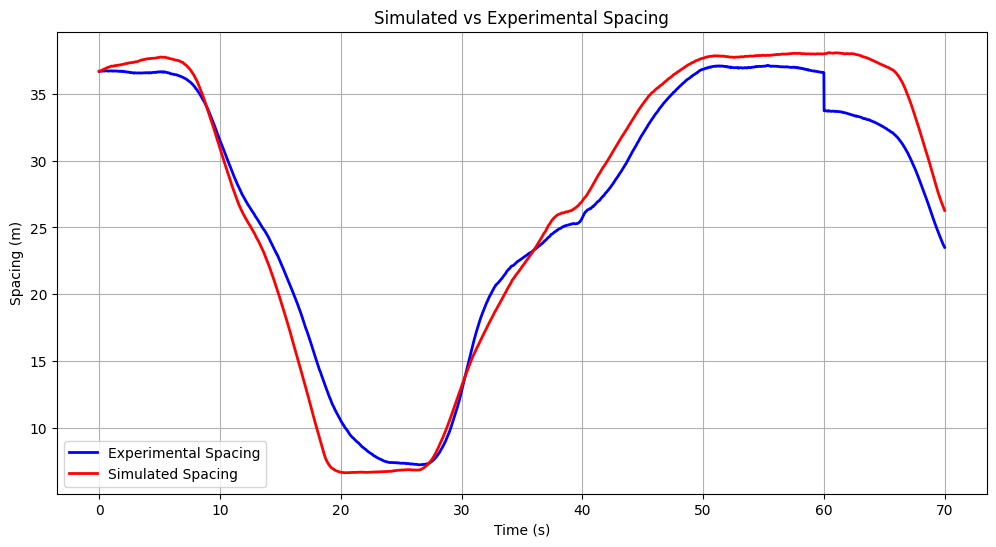

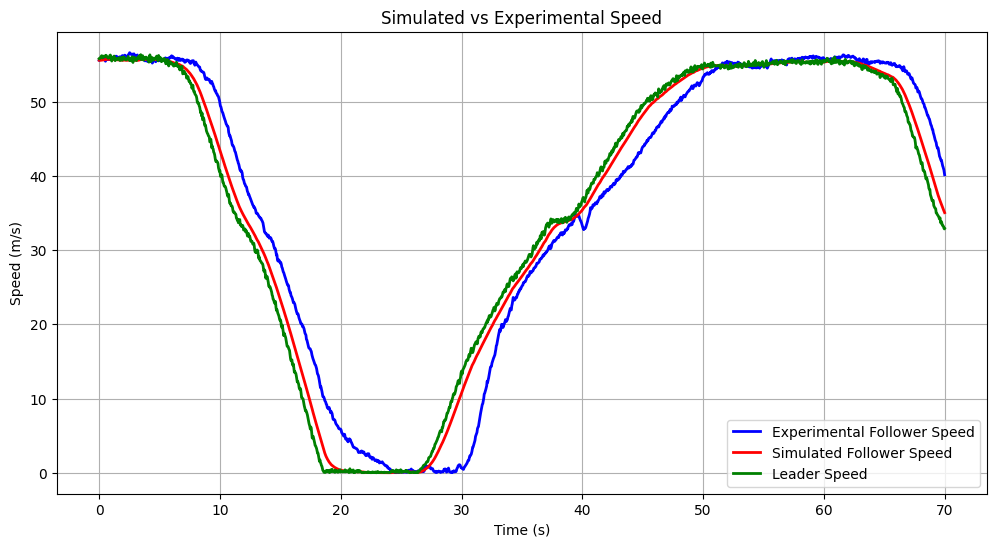

In [30]:
test_and_viz_full_dataset(xlong_gap_df, xlong_gap_best_params, limit=(0, 70))